# https://medium.com/@guildbilla/steel-defect-detection-image-segmentation-using-keras-dae8b4f986f0

# Threshold

# use model set before 0108 , submissions :
 
---

Label Thresholds: 0.7, 0.7, 0.6, 0.6

Pixel Thresholds: 0.4, 0.4, 0.4, 0.4

0108_1 KAGGLE score : 0.86318

---

Label Thresholds: 0.95, 0.85, 0.85, 0.85

Pixel Thresholds: 0.5, 0.5, 0.75, 0.5

0104_2 KAGGLE score : 0.88314

---

Label Thresholds: 0.9, 0.85, 0.85, 0.85

Pixel Thresholds: 0.4, 0.4, 0.4, 0.4

0108_2 KAGGLE score : 0.87361

---



In [1]:
from google.colab import drive
import os
drive.mount('/content/gdrive')

import os
os.chdir('/content/gdrive/My Drive/Colab Notebooks/final_project')

Mounted at /content/gdrive


In [2]:
!pip install segmentation_models

     |████████████████████████████████| 51kB 7.6MB/s 


In [3]:
!pip install q tensorflow==2.1
!pip install q keras==2.3.1

     |████████████████████████████████| 421.8MB 24kB/s 
     |████████████████████████████████| 450kB 46.6MB/s 
     |████████████████████████████████| 3.9MB 45.2MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=dd9a8fc7ad4c55b2558d470be48b664d6392fe839327a0c62f0fcb3b80c6721c
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.0
    Uninstalling tensorboard-2.4.0:
      Successfully uninstalled tensorboard-2.4.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: 

In [4]:
# Import libraries
import warnings
warnings.filterwarnings("ignore")

from time import time
import pandas as pd
import numpy as np
import os 
import cv2
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import segmentation_models
print(segmentation_models.__version__)

from sklearn.metrics import classification_report, multilabel_confusion_matrix

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.layers import GlobalAveragePooling2D, Dense, Conv2D, BatchNormalization, Dropout
from keras.models import Model, load_model
import tensorflow as tf
from tensorflow.python.keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import seaborn
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models import get_preprocessing

import albumentations as A
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import Sequence

Using TensorFlow backend.


Segmentation Models: using `keras` framework.
1.0.1



Utility functions, metrics and DataGenerator

In [5]:
# We need a function to convert EncodedPixels into mask
# https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

# Below metrics are useful for loading saved models

# https://www.kaggle.com/xhlulu/severstal-simple-keras-u-net-boilerplate
# COMPETITION METRIC 
def dice_coef(y_true, y_pred, smooth=K.epsilon()):
    '''
    This function returns dice coefficient of similarity between y_true and y_pred
    Dice coefficient is also referred to as F1_score, but we will use this name for image segmentation models
    For example, 
    let an instance on y_true and y_pred be [[1,1],[0,1]] and [[1,0],[0,1]]
    this metric first converts the above into [1,1,0,1] abd [1,0,0,1],
    then intersection is calculated as 1*1 + 1*0 + 0*1 + 1*1 = 2 and sum(y_true)+sum(y_pred)= 3+2 = 5
    this returns the value (2.* 2 + 10e-7)/(3 + 2 + 10e-7) ~ 0.8    
    '''
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Custom metrics, https://stackoverflow.com/questions/59196793/why-are-my-metrics-of-my-cnn-not-changing-with-each-epoch
def recall_m(y_true, y_pred):
    '''
    This function returns recall_score between y_true and y_pred
    This function is ported as a metric to the Neural Network Models
    Keras backend is used to take care of batch type training, the metric takes in a batch of y_pred and corresponding y_pred 
    as input and returns recall score of the batch
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # calculates number of true positives
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))      # calculates number of actual positives
    recall = true_positives / (possible_positives + K.epsilon())   # K.epsilon takes care of non-zero divisions
    return recall

def precision_m(y_true, y_pred):
    '''
    This function returns precison_score between y_true and y_pred
    This function is ported as a metric to the Neural Network Models
    Keras backend is used to take care of batch type training, the metric takes in a batch of y_pred and corresponding y_pred 
    as input and returns prediction score of the batch
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))  # calculates number of true positives
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))      # calculates number of predicted positives   
    precision = true_positives /(predicted_positives + K.epsilon()) # K.epsilon takes care of non-zero divisions
    return precision
    
def f1_score_m(y_true, y_pred):
    '''
    This function returns f1_score between y_true and y_pred
    This 
    This function is ported as a metric to the Neural Network Models
    Keras backend is used to take care of batch type training, the metric takes in a batch of y_pred and corresponding y_pred 
    as input and returns f1 score of the batch
    '''
    precision = precision_m(y_true, y_pred)  # calls precision metric and takes the score of precision of the batch
    recall = recall_m(y_true, y_pred)        # calls recall metric and takes the score of precision of the batch
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def area(i):
    '''
    Input: EncodedPixels (str)
    Output: number of pixels having the defect
    '''
    return sum([int(k) for k in i.split(' ')[1::2]])

class test_DataGenerator_3(keras.utils.Sequence):
    def __init__(self, df, batch_size = 1, image_path = './raw_data/',
                 preprocess=None, info={}):
        super().__init__()
        self.df = df
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.info = info
        self.data_path = image_path
        self.on_epoch_end()
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
    def __getitem__(self, index): 
        '''
        The DataGenerator takes ImageIds of batch size 1 and returns Image array to the model.
        With the help of ImageIds the DataGenerator locates the Image file in the path, the image is read and resized from
        256x1600 to 256x800.
        '''
        X = np.empty((self.batch_size,256,800,3),dtype=np.float32)
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,f in enumerate(self.df['ImageId'].iloc[indexes]):
            self.info[index*self.batch_size+i]=f
            X[i,] = Image.open(self.data_path + f).resize((800,256))      
        if self.preprocess!=None: X = self.preprocess(X)
        return X


In [19]:
class AugmentDataGenerator(Sequence):
    def __init__(self, datagen, augment=None):
        self.datagen = datagen
        if augment is None:
            self.augment = A.Compose([])
        else:
            self.augment = augment

    def __len__(self):
        return len(self.datagen)

    def __getitem__(self, x):
        images, *rest = self.datagen[x]
        augmented = []
        for image in images:
            image = self.augment(image=image)['image']
            augmented.append(image)
        return (np.array(augmented), *rest)

Loading Data and saved Models

In [6]:
#! 7z e './severstal-steel-defect-detection.zip' -oraw_data   train_images/*.jpg  # https://stackoverflow.com/questions/31984387/command-line-for-7z-to-extract-specific-files-from-specific-folders-inside-an-ar
train_image_names = os.listdir('./train_images/')

#! 7z e './severstal-steel-defect-detection.zip' -oraw_data   test_images/*.jpg
test_image_names = [i for i in os.listdir('./raw_data') if i not in train_image_names]

#! 7z e './severstal-steel-defect-detection.zip' -oraw_data   train.csv
trainLabels = pd.read_csv('./train.csv')

In [7]:
dependencies = {
        'recall_m':recall_m,
        'precision_m':precision_m,
        'dice_coef':dice_coef,
        'f1_score_m':f1_score_m,
        'dice_loss':sm.losses.dice_loss
    }

Load Models

In [8]:
print('Load binary model in ...')
model_binary = load_model('./binary_model_1204.hdf5', custom_objects=dependencies)
print('Load multi class model in ...')
model_multi = load_model('./multi_class_model_1229.h5', custom_objects=dependencies) #0105
print('Load segmentation models in ...')
model_segment_1 = load_model('./segment_model_defect1_0103.h5', custom_objects=dependencies)
model_segment_2 = load_model('./segment_model_defect2_0103.h5', custom_objects=dependencies) #0105
model_segment_3 = load_model('./segment_model_defect3_0103.h5', custom_objects=dependencies)
model_segment_4 = load_model('./segment_model_defect4_0103.h5', custom_objects=dependencies)

Load binary model in ...
Load multi class model in ...
Load segmentation models in ...


Predictor functions

In [9]:
def pred_classification(X):
    '''
    Input: ImageIds in form of a dataframe
    Return: Predictions of classification models
    '''
    X = X.reset_index().drop('index',axis=1)
    data_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(dataframe=X, directory='./raw_data/',
                                                                            x_col="ImageId", class_mode = None, 
                                                                            target_size=(256,512), batch_size=1, shuffle=False)
    #add 0108
    data_generator = AugmentDataGenerator(data_generator, augment= None)

    data_preds_binary = model_binary.predict_generator(data_generator,verbose=0)
    data_preds_multi_label = model_multi.predict_generator(data_generator,verbose=0)
    data_classification = pd.DataFrame(data_preds_multi_label, columns = ['defect_1','defect_2','defect_3','defect_4'])
    data_classification['hasDefect'] = data_preds_binary
    data_classification['ImageId'] = X['ImageId']
    return data_classification[['ImageId','hasDefect','defect_1','defect_2','defect_3','defect_4']]

In [10]:
def pred_segmentation(X):
    '''
    Input: ImageIds in form of a dataframe
    Return: Predictions of segmentation models
    '''
    X = X.reset_index().drop('index',axis=1)
    preprocess = get_preprocessing('efficientnetb1')
    tmp=[]
    loop_num = 50
    for j in range((len(X)//loop_num)+1):
        test_dataf = X[loop_num*j:loop_num*j+loop_num]
        test_batches =  test_DataGenerator_3(test_dataf,preprocess=preprocess)
        test_preds_1 = model_segment_1.predict_generator(test_batches,verbose=0)
        test_preds_2 = model_segment_2.predict_generator(test_batches,verbose=0)
        test_preds_3 = model_segment_3.predict_generator(test_batches,verbose=0)
        test_preds_4 = model_segment_4.predict_generator(test_batches,verbose=0)
        for i in range(len(test_preds_1)):
            ep1 = mask2rle(np.array((Image.fromarray((test_preds_1[i][:,:,0])>=0.5)).resize((1600,256))).astype(int))
            ep2 = mask2rle(np.array((Image.fromarray((test_preds_2[i][:,:,0])>=0.5)).resize((1600,256))).astype(int))
            ep3 = mask2rle(np.array((Image.fromarray((test_preds_3[i][:,:,0])>=0.5)).resize((1600,256))).astype(int))
            ep4 = mask2rle(np.array((Image.fromarray((test_preds_4[i][:,:,0])>=0.5)).resize((1600,256))).astype(int))
            tmp.append([test_dataf.ImageId.iloc[i],ep1,ep2,ep3,ep4])

    return pd.DataFrame(tmp,columns=['ImageId','EncodedPixels_1','EncodedPixels_2','EncodedPixels_3','EncodedPixels_4'])

In [15]:
def pred_combined(X):
    '''
    Input: ImageId (dataframe)
    Return: Comdined dataframe of output of pred_classification function and pred_segmentation function
    '''
    X = X.reset_index().drop('index',axis=1)
    return pred_classification(X).merge(pred_segmentation(X),on=['ImageId'])
    
def steel_prediction(X):
    '''
    Function-1:
    Input: ImageId(dataframe)
    Process: Calls pred_combined which calls pred_classification and pred_segmentation
            Applies thresholds -> area and classification probability
    Return: DataFrame (columns = ImageId_ClassId,EncodedPixels)
    
    '''
    X = X.reset_index().drop('index',axis=1)
    p = pred_combined(X)
    tmp = []
    for i in range(len(p)):        
        j, b, m1, m2, m3, m4, ep1, ep2, ep3, ep4 = p.iloc[i]
        # randomly selected classification threshold values to get high recall 
        # for no defect binary classifier and high precision for multi-label classifier 
        # while not compromising much on other metrics
        
        # area thresholds are determined from EDA performed only on train dataset

        # ------------- threshold can modified ------------------ #

        if area(ep1)>=600 and b>=0.90 and m1>=0.4: 
            tmp.append([j+'_1',ep1])
        else:
            tmp.append([j+'_1',''])

        if area(ep2)>=600 and b>=0.85 and m2>=0.4:
            tmp.append([j+'_2',ep2])
        else:
            tmp.append([j+'_2',''])

        if area(ep3)>=900 and b>=0.85 and m3>=0.4:
            tmp.append([j+'_3',ep3])
        else:
            tmp.append([j+'_3',''])
            
        if area(ep4)>=2000 and b>=0.85 and m4>=0.4:
            tmp.append([j+'_4',ep4])
        else:
            tmp.append([j+'_4',''])
    return pd.DataFrame(tmp, columns = ['ImageId_ClassId','EncodedPixels'])


steel_prediction() is final functions defined for generating predictions

# ***MAKE PREDICT***

Determining time taken by the model for generating predictions on a new unseen image:

In [12]:
raw_test = pd.DataFrame(test_image_names,columns=['ImageId'])

In [15]:
%timeit c2 = steel_prediction(raw_test[0:10])

Found 10 validated image filenames.
Found 10 validated image filenames.
Found 10 validated image filenames.
Found 10 validated image filenames.
The slowest run took 12.99 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 2.36 s per loop


10 images 2.27 sec

Generating Predictions on raw test dataset for submission on Kaggle

In [16]:
c2 = steel_prediction(raw_test)
c2.to_csv('./severstal_final_test_preds_0108_2.csv',index=False)
c2.shape


Found 5506 validated image filenames.


(22024, 2)

---

# ***Evaluation(unfinish)***

Evaluate on training data

In [14]:
def get_data():    
    '''
    Used to generate X_train, X_val and X_test, each include corresponding Y data also
    (Raw Data)
    '''
    tr_img_id = []
    tr_cls_id = []
    for i in train_image_names:
        tr_img_id.append(i)
        tr_cls_id.append(1)
        tr_img_id.append(i)
        tr_cls_id.append(2)
        tr_img_id.append(i)
        tr_cls_id.append(3)
        tr_img_id.append(i)
        tr_cls_id.append(4)
    train_img_nms = pd.DataFrame(tr_img_id,columns=['ImageId'])
    train_img_nms['ClassId'] = tr_cls_id

    train_df = pd.merge(train_img_nms, trainLabels,how='outer',on=['ImageId','ClassId'])
    train_df = train_df.fillna('')

    train_data = pd.pivot_table(train_df, values='EncodedPixels', index='ImageId',columns='ClassId', aggfunc=np.sum).astype(str)
    train_data = train_data.reset_index()
    train_data.columns = ['ImageId','Defect_1','Defect_2','Defect_3','Defect_4']

    tmp = []
    for i in range(len(train_data)):
        if all((train_data['Defect_1'][i]=='',train_data['Defect_2'][i]=='',train_data['Defect_3'][i]=='',train_data['Defect_4'][i]=='')):
            tmp.append(0)
        else:
            tmp.append(1)
    train_data['hasDefect'] = tmp

    tmp = []
    for i in range(len(train_data)):
        if train_data['Defect_1'][i]=='':
            tmp.append(0)
        else:
            tmp.append(1)
    train_data['hasDefect_1'] = tmp

    tmp = []
    for i in range(len(train_data)):
        if train_data['Defect_2'][i]=='':
            tmp.append(0)
        else:
            tmp.append(1)
    train_data['hasDefect_2'] = tmp

    tmp = []
    for i in range(len(train_data)):
        if train_data['Defect_3'][i]=='':
            tmp.append(0)
        else:
            tmp.append(1)
    train_data['hasDefect_3'] = tmp

    tmp = []
    for i in range(len(train_data)):
        if train_data['Defect_4'][i]=='':
            tmp.append(0)
        else:
            tmp.append(1)
    train_data['hasDefect_4'] = tmp


    # For stratified sampling, stratified based on minority label priority
    # Label 2 : 247
    # Label 4 : 801
    # Label 1 : 897
    # Label 3 : 5150
    tmp = []
    for i in range(len(train_data)):
        if train_data['hasDefect_2'].iloc[i]==1:
            tmp.append(2)
        elif train_data['hasDefect_4'].iloc[i]==1:
            tmp.append(4)
        elif train_data['hasDefect_1'].iloc[i]==1:
            tmp.append(1)
        elif train_data['hasDefect_3'].iloc[i]==1:
            tmp.append(3)
        else:
            tmp.append(0)
    train_data['stratify']=tmp

    X = train_data.copy()
    X_train, X_test = train_test_split(X, test_size = 0.1, stratify = X['stratify'],random_state=42)
    X_train, X_val = train_test_split(X_train, test_size = 0.2, stratify = X_train['stratify'],random_state=42)
    X_train = X_train.drop(['stratify'], axis = 1)
    X_val = X_val.drop(['stratify'], axis = 1)
    X_test = X_test.drop(['stratify'], axis = 1)
    return X_train, X_val, X_test

In [19]:
# For Evaluate  
# Loading datasets from raw train dataset
train, val, test = get_data()
print(train.shape, val.shape, test.shape)

(9048, 10) (2263, 10) (1257, 10)


In [18]:
def dice_metric(str_true,str_pred):
    '''
    Input: true and predicted EncodedPixel strings
    Checks for empty strings and determines dice coefficient of non empty (str_true,str_pred) pair
    Return: Dice similarity coefficient of the two strings
    '''
    if str_true=='' and str_pred=='':
        return 1
    elif str_true!='' and str_pred!='':
        y_true_f = rle2mask(str_true).flatten() 
        y_pred_f = rle2mask(str_pred).flatten() 
        intersection = sum(y_true_f * y_pred_f)
        return np.round((2. * intersection + K.epsilon()) / (sum(y_true_f) + sum(y_pred_f) + K.epsilon()),8)
    else: 
        return 0

    
    
def steel_evaluation(X,Y):   
    '''
    Function-2:
    Input: ImageId (DataFrame), defect details
    Calls steel_prediction() and dice_metric()
    Return: metrics, classification_report and confusion_matrix
    '''
    X = X.reset_index().drop('index',axis=1)
    Y = Y.reset_index().drop('index',axis=1)
    c1 = steel_prediction(X)
    c1['ImageId'] = c1['ImageId_ClassId'].apply(lambda s: s.split('_')[0])
    c1['ClassId'] = c1['ImageId_ClassId'].apply(lambda s: s.split('_')[1])
    c1 = pd.pivot_table(c1, values='EncodedPixels', index='ImageId',columns='ClassId', aggfunc=np.sum).astype(str)
    c1 = c1.reset_index()
    c1.columns = ['ImageId','Defect_1','Defect_2','Defect_3','Defect_4']
    c1 = X.merge(c1, how = 'inner',on='ImageId',sort = False)
    
    tmp = []
    for i in range(len(c1)):
        if all((c1['Defect_1'][i]=='',c1['Defect_2'][i]=='',c1['Defect_3'][i]=='',c1['Defect_4'][i]=='')):
            tmp.append(0)
        else:
            tmp.append(1)
    c1['hasDefect'] = tmp

    tmp = []
    for i in range(len(c1)):
        if c1['Defect_1'][i]=='':
            tmp.append(0)
        else:
            tmp.append(1)
    c1['hasDefect_1'] = tmp

    tmp = []
    for i in range(len(c1)):
        if c1['Defect_2'][i]=='':
            tmp.append(0)
        else:
            tmp.append(1)
    c1['hasDefect_2'] = tmp

    tmp = []
    for i in range(len(c1)):
        if c1['Defect_3'][i]=='':
            tmp.append(0)
        else:
            tmp.append(1)
    c1['hasDefect_3'] = tmp

    tmp = []
    for i in range(len(c1)):
        if c1['Defect_4'][i]=='':
            tmp.append(0)
        else:
            tmp.append(1)
    c1['hasDefect_4'] = tmp

    Y[['NoDefect']] = 1 - Y[['hasDefect']]
    c1[['NoDefect']] = 1 - c1[['hasDefect']]

    y_true = Y[['Defect_1', 'Defect_2', 'Defect_3', 'Defect_4', 'hasDefect_1', 'hasDefect_2', 'hasDefect_3', 'hasDefect_4', 'NoDefect']].fillna('')
    y_pred = c1[['Defect_1', 'Defect_2', 'Defect_3', 'Defect_4', 'hasDefect_1', 'hasDefect_2', 'hasDefect_3', 'hasDefect_4', 'NoDefect']].fillna('')

    EncodedPixels_1 = y_true[['Defect_1']]
    EncodedPixels_1.columns = ['Defect_1_true']
    EncodedPixels_1['Defect_1_pred'] = y_pred[['Defect_1']]
    EncodedPixels_1['dice'] = EncodedPixels_1.apply(lambda x: dice_metric(x.Defect_1_true,x.Defect_1_pred),axis=1)
    dice_1 = EncodedPixels_1['dice'].fillna(0).sum()
    dice_1 /= len(EncodedPixels_1)

    EncodedPixels_2 = y_true[['Defect_2']]
    EncodedPixels_2.columns = ['Defect_2_true']
    EncodedPixels_2['Defect_2_pred'] = y_pred[['Defect_2']]
    EncodedPixels_2['dice'] = EncodedPixels_2.apply(lambda x: dice_metric(x.Defect_2_true,x.Defect_2_pred),axis=1)
    dice_2 = EncodedPixels_2['dice'].fillna(0).sum()
    dice_2 /= len(EncodedPixels_2)

    EncodedPixels_3 = y_true[['Defect_3']]
    EncodedPixels_3.columns = ['Defect_3_true']
    EncodedPixels_3['Defect_3_pred'] = y_pred[['Defect_3']]
    EncodedPixels_3['dice'] = EncodedPixels_3.apply(lambda x: dice_metric(x.Defect_3_true,x.Defect_3_pred),axis=1)
    dice_3 = EncodedPixels_3['dice'].fillna(0).sum()
    dice_3 /= len(EncodedPixels_3)

    EncodedPixels_4 = y_true[['Defect_4']]
    EncodedPixels_4.columns = ['Defect_4_true']
    EncodedPixels_4['Defect_4_pred'] = y_pred[['Defect_4']]
    EncodedPixels_4['dice'] = EncodedPixels_4.apply(lambda x: dice_metric(x.Defect_4_true,x.Defect_4_pred),axis=1)
    dice_4 = EncodedPixels_4['dice'].fillna(0).sum()
    dice_4 /= len(EncodedPixels_4)

    dice_overall = (dice_1 + dice_2 + dice_3 + dice_4)/4
    y_true[['hasDefect_1', 'hasDefect_2', 'hasDefect_3', 'hasDefect_4', 'NoDefect']] = y_true[['hasDefect_1', 'hasDefect_2', 'hasDefect_3', 'hasDefect_4', 'NoDefect']].fillna(0).astype(int)
    y_pred[['hasDefect_1', 'hasDefect_2', 'hasDefect_3', 'hasDefect_4', 'NoDefect']] = y_pred[['hasDefect_1', 'hasDefect_2', 'hasDefect_3', 'hasDefect_4', 'NoDefect']].fillna(0).astype(int)
    
    cls_repo = classification_report(y_true[['hasDefect_1', 'hasDefect_2', 'hasDefect_3', 'hasDefect_4', 'NoDefect']], \
                                     y_pred[['hasDefect_1', 'hasDefect_2', 'hasDefect_3', 'hasDefect_4', 'NoDefect']], \
                                     target_names = ['hasDefect_1', 'hasDefect_2', 'hasDefect_3', 'hasDefect_4', 'NoDefect'])
    
    conf_mat = multilabel_confusion_matrix(y_true[['hasDefect_1', 'hasDefect_2', 'hasDefect_3', 'hasDefect_4', 'NoDefect']], y_pred[['hasDefect_1', 'hasDefect_2', 'hasDefect_3', 'hasDefect_4', 'NoDefect']])
    return [[dice_1,dice_2,dice_3,dice_4],[dice_overall], [cls_repo], [conf_mat]]
    
    
    
def plt_confusion(d):
    '''
    Input: Confusion_matrix
    Output: Seaborn heatmap visualization (OneVersusRest mode of confusion matrices)
    '''
    fig, ax = plt.subplots(1,5,figsize=(20,4))
    for i in range(4):
        seaborn.heatmap(d[i],annot=True,fmt='d',cmap="Reds", ax = ax[i])
        ax[i].set_ylabel('Actual')
        ax[i].set_xlabel('Predicted')
        ax[i].set_title(f'Defect_{i+1} confusion matrix')
    seaborn.heatmap(d[4],annot=True,fmt='d',cmap="Reds", ax = ax[4])
    ax[4].set_ylabel('Actual')
    ax[4].set_xlabel('Predicted')
    ax[4].set_title('No defect confusion matrix')
    plt.show()

steel_evaluation() is final functions defined for generating evaluations


Evaluation on a sample single ImageId

Found 1 validated image filenames.
--------------------------------------------------
Dice coefficient of each segmentation mask compared with true mask: [defect_1, defect_2, defect_3, defect_4]
[1.0, 1.0, 1.0, 1.0]
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

 hasDefect_1       0.00      0.00      0.00         0
 hasDefect_2       0.00      0.00      0.00         0
 hasDefect_3       0.00      0.00      0.00         0
 hasDefect_4       0.00      0.00      0.00         0
    NoDefect       1.00      1.00      1.00         1

   micro avg       1.00      1.00      1.00         1
   macro avg       0.20      0.20      0.20         1
weighted avg       1.00      1.00      1.00         1
 samples avg       1.00      1.00      1.00         1

--------------------------------------------------
Confusion matrix: 


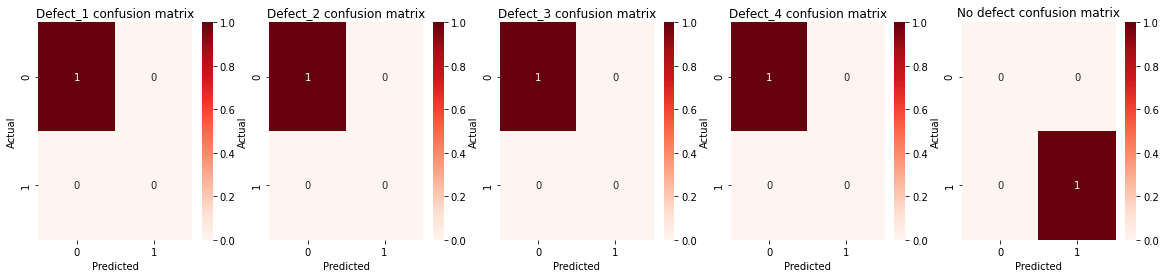

--------------------------------------------------
Mean Dice Coefficient: (Competition Metric)
1.0
--------------------------------------------------
CPU times: user 1.29 s, sys: 221 ms, total: 1.51 s
Wall time: 1.81 s


In [31]:
%%time
X = train[['ImageId']][2:3]
Y = train[['Defect_1', 'Defect_2', 'Defect_3', 'Defect_4', 'hasDefect_1', 'hasDefect_2', 'hasDefect_3', 'hasDefect_4', 'hasDefect']][2:3]
dce = steel_evaluation(X, Y)
print('-'*50)
print('Dice coefficient of each segmentation mask compared with true mask: [defect_1, defect_2, defect_3, defect_4]') # Mean for each defect
print(dce[0]) # dice coefficient
print('-'*50)
print('Classification Report:')
print(dce[2][0])
print('-'*50)
print('Confusion matrix: ')
plt_confusion(dce[3][0])
print('-'*50)
print('Mean Dice Coefficient: (Competition Metric)')
print(dce[1][0]) # dice coefficient
print('-'*50)

Evaluation on a batch of ImageIds

Found 17 validated image filenames.
--------------------------------------------------
Dice coefficient of each segmentation mask compared with true mask: [defect_1, defect_2, defect_3, defect_4]
[1.0, 0.8823529411764706, 0.9212558941176471, 1.0]
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

 hasDefect_1       0.00      0.00      0.00         0
 hasDefect_2       0.00      0.00      0.00         2
 hasDefect_3       1.00      1.00      1.00         4
 hasDefect_4       0.00      0.00      0.00         0
    NoDefect       0.85      1.00      0.92        11

   micro avg       0.88      0.88      0.88        17
   macro avg       0.37      0.40      0.38        17
weighted avg       0.78      0.88      0.83        17
 samples avg       0.88      0.88      0.88        17

--------------------------------------------------
Confusion matrix: 


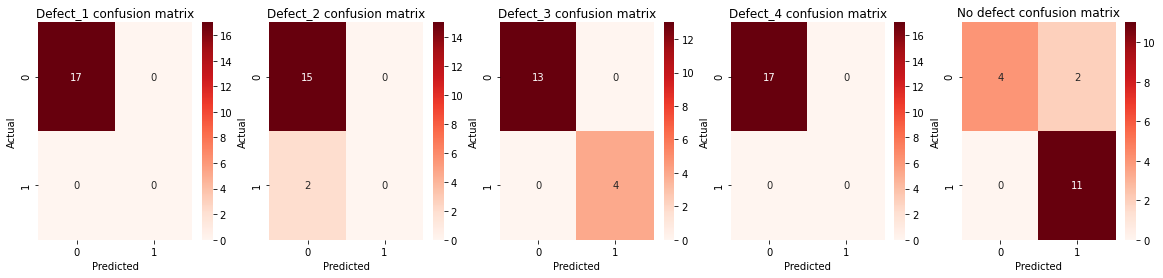

--------------------------------------------------
Mean Dice Coefficient: (Competition Metric)
0.9509022088235294
--------------------------------------------------
CPU times: user 6.48 s, sys: 792 ms, total: 7.27 s
Wall time: 5.69 s


In [32]:
%%time
X = train[['ImageId']][3:20]
Y = train[['Defect_1', 'Defect_2', 'Defect_3', 'Defect_4', 'hasDefect_1', 'hasDefect_2', 'hasDefect_3', 'hasDefect_4', 'hasDefect']][3:20]
dce = steel_evaluation(X, Y)
print('-'*50)
print('Dice coefficient of each segmentation mask compared with true mask: [defect_1, defect_2, defect_3, defect_4]') # Mean for each defect
print(dce[0]) # dice coefficient
print('-'*50)
print('Classification Report:')
print(dce[2][0])
print('-'*50)
print('Confusion matrix: ')
plt_confusion(dce[3][0])
print('-'*50)
print('Mean Dice Coefficient: (Competition Metric)')
print(dce[1][0]) # dice coefficient
print('-'*50)